## Importo todo lo necesario para trabajar

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.model_selection import GroupShuffleSplit 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Abro datasets y hago split en base a artistas al azar. Genero sets de entrenamiento, validación y testeo.

In [ ]:
df_train = pd.read_parquet('/content/drive/MyDrive/ODD tp 1 dataset/train.parquet')

In [ ]:
df_test = pd.read_parquet('/content/drive/MyDrive/ODD tp 1 dataset/test.parquet')

**Agarro y separo 80/20 el df_train al azar por la columna artista para así conseguir sets de entrenamiento y validación**

In [ ]:
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 26)
split = splitter.split(df_train, groups=df_train['artist'])
train_inds, valid_inds = next(split)

train = df_train.iloc[train_inds]
valid = df_train.iloc[valid_inds]

In [ ]:
y_train = train.genre
X_train = train.drop(["track_name", "a_genres", "did", "genre", 'artist'], axis = 1)

In [ ]:
y_valid = valid.genre
X_valid = valid.drop(["track_name", "a_genres", "did", "genre", 'artist'], axis = 1)

In [ ]:
y_test = df_test.genre
X_test = df_test.drop(["track_name", "a_genres", "did", "genre", 'artist'], axis = 1)

# Feature engineering

**Filleo, encodeo con OHE y joine "language"**

In [ ]:
X_valid['language'] = X_valid['language'].fillna(X_train['language'].mode()[0])
X_train['language'] = X_train['language'].fillna(X_train['language'].mode()[0])
X_test['language'] = X_test['language'].fillna(X_train['language'].mode()[0])

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore' )
lenguaje_train = encoder.fit_transform(X_train[['language']]).todense().astype(int)
encoder.get_feature_names_out()

array(['language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw'], dtype=object)

In [ ]:
lenguaje_valid = encoder.transform(X_valid[['language']]).todense().astype(int)
encoder.get_feature_names_out()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


array(['language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw'], dtype=object)

In [ ]:
lenguaje_test = encoder.transform(X_test[['language']]).todense().astype(int)
encoder.get_feature_names_out()

array(['language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw'], dtype=object)

In [ ]:
X_train = X_train.reset_index().drop(['index', 'language'], axis=1).join(pd.DataFrame(lenguaje_train, columns = ('language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw')))
X_valid = X_valid.reset_index().drop(['index', 'language'], axis=1).join(pd.DataFrame(lenguaje_valid, columns = ('language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw')))
X_test = X_test.reset_index().drop(['index', 'language'], axis=1).join(pd.DataFrame(lenguaje_test, columns = ('language_de', 'language_en', 'language_es', 'language_fr',
       'language_ga', 'language_gl', 'language_is', 'language_it',
       'language_pt', 'language_rw')))

**Filleo "s-label"**

In [ ]:
X_valid['s-label'] = X_valid['s-label'].fillna(X_train['s-label'].median())
X_train['s-label'] = X_train['s-label'].fillna(X_train['s-label'].median())
X_test['s-label'] = X_test['s-label'].fillna(X_train['s-label'].median())

**Encodeo con OHE "Mode"**

In [ ]:
mode_train = encoder.fit_transform(X_train[['mode']]).todense().astype(int)
encoder.get_feature_names_out()

array(['mode_Minor'], dtype=object)

In [ ]:
mode_valid = encoder.transform(X_valid[['mode']]).todense().astype(int)
encoder.get_feature_names_out()

array(['mode_Minor'], dtype=object)

In [ ]:
mode_test = encoder.transform(X_test[['mode']]).todense().astype(int)
encoder.get_feature_names_out()

array(['mode_Minor'], dtype=object)

In [ ]:
X_train = X_train.reset_index().drop(['index', 'mode'], axis=1).join(pd.DataFrame(mode_train, columns = ('mode_Minor', )))
X_valid = X_valid.reset_index().drop(['index', 'mode'], axis=1).join(pd.DataFrame(mode_valid, columns = ('mode_Minor', )))
X_test = X_test.reset_index().drop(['index', 'mode'], axis=1).join(pd.DataFrame(mode_test, columns = ('mode_Minor', )))

**Encodeo con OHE "time signature"**

In [ ]:
time_train = encoder.fit_transform(X_train[['time_signature']]).todense().astype(int)
encoder.get_feature_names_out()

array(['time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4'],
      dtype=object)

In [ ]:
time_valid = encoder.transform(X_valid[['time_signature']]).todense().astype(int)
encoder.get_feature_names_out()

array(['time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4'],
      dtype=object)

In [ ]:
time_test = encoder.transform(X_test[['time_signature']]).todense().astype(int)
encoder.get_feature_names_out()

array(['time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4'],
      dtype=object)

In [ ]:
X_train = X_train.reset_index().drop(['index', 'time_signature'], axis=1).join(pd.DataFrame(time_train, columns = ('time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4')))
X_valid = X_valid.reset_index().drop(['index', 'time_signature'], axis=1).join(pd.DataFrame(time_valid, columns = ('time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4')))
X_test = X_test.reset_index().drop(['index', 'time_signature'], axis=1).join(pd.DataFrame(time_test, columns = ('time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4')))

**Encodeo con OHE "key"**

In [ ]:
key_train =  encoder.fit_transform(X_train[['key']]).todense().astype(int)
encoder.get_feature_names_out()

array(['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#'], dtype=object)

In [ ]:
key_valid =  encoder.transform(X_valid[['key']]).todense().astype(int)
encoder.get_feature_names_out()

array(['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#'], dtype=object)

In [ ]:
key_test =  encoder.transform(X_test[['key']]).todense().astype(int)
encoder.get_feature_names_out()

array(['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#'], dtype=object)

In [ ]:
X_train = X_train.reset_index().drop(['index', 'key'], axis=1).join(pd.DataFrame(key_train, columns = ('key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#')))
X_valid = X_valid.reset_index().drop(['index', 'key'], axis=1).join(pd.DataFrame(key_valid, columns = ('key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#')))
X_test = X_test.reset_index().drop(['index', 'key'], axis=1).join(pd.DataFrame(key_test, columns = ('key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E',
       'key_F', 'key_F#', 'key_G', 'key_G#')))

**Filleo NaNs, vectorizo y joineo "lyric"**

In [ ]:
X_train["lyric"] = X_train["lyric"].fillna("")
X_valid["lyric"] = X_valid["lyric"].fillna("")
X_test["lyric"] = X_test["lyric"].fillna("")

In [ ]:
countIDF = TfidfVectorizer(lowercase=True, stop_words='english', max_features=50)
matrizVectoresIDF = countIDF.fit_transform(X_train["lyric"]).todense().astype(int)

In [ ]:
matrizVectoresIDF_valid = countIDF.transform(X_valid["lyric"]).todense().astype(int)
matrizVectoresIDF_test = countIDF.transform(X_test["lyric"]).todense().astype(int)


In [ ]:
X_train = X_train.reset_index().drop(['index', 'lyric'], axis=1).join(pd.DataFrame(matrizVectoresIDF))
X_valid = X_valid.reset_index().drop(['index', 'lyric'], axis=1).join(pd.DataFrame(matrizVectoresIDF_valid))
X_test = X_test.reset_index().drop(['index', 'lyric'], axis=1).join(pd.DataFrame(matrizVectoresIDF_test))

**Normalizo los** **valores**

In [ ]:
escalador = MinMaxScaler()

X_train_escalado = escalador.fit_transform(X_train)
X_train = pd.DataFrame(X_train_escalado, columns = X_train.columns)

X_valid_escalado = escalador.transform(X_valid)
X_valid = pd.DataFrame(X_valid_escalado, columns = X_valid.columns)

X_test_escalado = escalador.transform(X_test)
X_test = pd.DataFrame(X_test_escalado, columns = X_test.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# Busco hiper parametros y hago modelo de regresion

In [ ]:
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=26)

espacio_busqueda = dict()
espacio_busqueda['solver'] = ['newton-cg', "sag",'saga']
espacio_busqueda['penalty'] = ['l2', 'l1']
espacio_busqueda['C'] = [10, 1, 50, 25]

busqueda_parametros = RandomizedSearchCV(model, espacio_busqueda, n_iter=50, scoring='accuracy', n_jobs=1, cv=cv, verbose=10, random_state=1)
resultados = busqueda_parametros.fit(X_train, y_train)

In [ ]:
resultados.best_params_

{'solver': 'saga', 'penalty': 'l1', 'C': 10}

In [ ]:
resultados.best_estimator_

LogisticRegression(C=10, penalty='l1', solver='saga')

In [ ]:
resultados.best_score_

0.3443684778697373

In [ ]:
# Uso los hiperparametros conseguidos por randomsearch para el modelo de regresion logistica 

logreg = LogisticRegression(C=10, solver='saga', penalty='l1', random_state=26)

modelo = logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


# ¿Cuál es el mejor score de validación obtenido? 

In [ ]:
print(f'El mejor score de validación obtenido es {top_k_accuracy_score(y_valid, logreg.predict_proba(X_valid), k=2, labels=modelo.classes_)}')

El mejor score de validación obtenido es 0.5037664783427496


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# Al predecir con este modelo para test, ¿Cúal es el score obtenido?

In [ ]:
print(f'Al predecir con este modelo para test, el resultado obtenido es {top_k_accuracy_score(y_test, logreg.predict_proba(X_test), k=2, labels=modelo.classes_)}')

Al predecir con este modelo para test, el resultado obtenido es 0.5050778605280974


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
predicciones_parte2 = pd.DataFrame(logreg.predict_proba(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Guardo csv con predicciones 

predicciones_parte2.to_csv('PrediccionesParteII')

# ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [ ]:
df = pd.DataFrame(modelo.coef_[0], index=X_train.columns).transpose()

In [ ]:
df

,popularity,a_songs,a_popularity,s-label,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,...,40,41,42,43,44,45,46,47,48,49
0,4.826686,-0.410964,16.095307,-0.360815,-1.913362,-1.522374,0.442169,2.759261,1.691719,-0.411249,...,0.0,1.369942,2.400163,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Creo lista de columnas para agrupar y sumar despues

language = ['language_de','language_en','language_es', 'language_fr', 'language_ga','language_gl','language_is','language_it','language_pt','language_rw']
time_signature = ['time_signature_3/4', 'time_signature_4/4','time_signature_5/4']
key = ['key_A#','key_B','key_C','key_C#','key_D','key_D#','key_E','key_F','key_F#','key_G','key_G#']
lyric = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]

# Sumo las columnas que se habian desagregado cuando les hice OHE 
# y las agrupo segun feature

df['language'] = df[language].sum(axis=1)
df['time_signature'] = df[time_signature].sum(axis=1)
df['key'] = df[key].sum(axis=1)
df['lyric'] = df[lyric].sum(axis=1)

In [ ]:
df = df[['popularity','a_songs','a_popularity','s-label','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','language','time_signature','key','lyric']]

In [ ]:
df = df.transpose().reset_index()

In [ ]:
df.rename(columns = {'index':'feature', 0:'suma'}, inplace = True)

In [ ]:
df["importancia"] = pow(math.e, df.suma)
df = df.sort_values(by = ["importancia"], ascending=False)
 
top_10_features = df[:10]

In [ ]:
top_10_features

,feature,suma,importancia
2,a_popularity,16.095307,9.774690e+06
17,lyric,15.120223,3.686628e+06
0,popularity,4.826686,1.247967e+02
14,language,4.001589,5.468495e+01
7,energy,2.759261,1.578818e+01
8,instrumentalness,1.691719,5.428805e+00
11,speechiness,0.548998,1.731518e+00
6,duration_ms,0.442169,1.556079e+00
16,key,0.433293,1.542328e+00
15,time_signature,0.143055,1.153793e+00


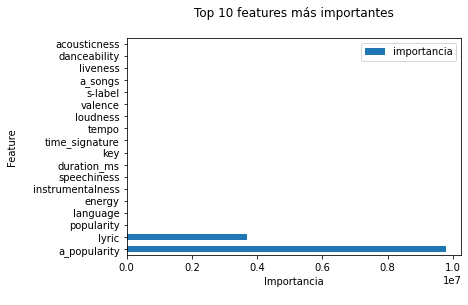

In [ ]:
ax = df.plot.barh(x='feature', y='importancia')
plt.title("Top 10 features más importantes\n")
plt.xlabel('Importancia\n') 
plt.ylabel('Feature\n')
plt.show()

Este es un ejemplo de como quedaria si no lo elevo a la potencia de e.

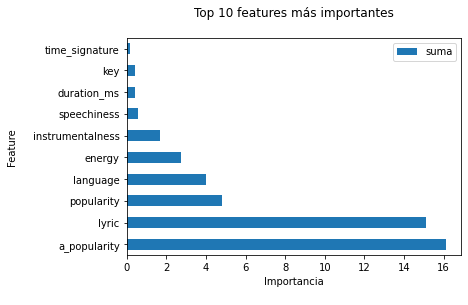

In [ ]:
ax = top_10_features.plot.barh(x='feature', y='suma')
plt.title("Top 10 features más importantes\n")
plt.xlabel('Importancia\n') 
plt.ylabel('Feature\n')
plt.show()